Source 
http://mc-stan.org/users/documentation/case-studies/radon.html?fbclid=IwAR3h_03XtQnyJQ18EOdREkPX-4biDX7c5AN5e9DPQzQLZ6hB2JRFh1gHemQ
http://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import stanity

In [2]:
star = pd.read_csv('Star.csv', index_col=0, header = 0)

In [3]:
star.head()

,tmathssk,treadssk,classk,totexpk,sex,freelunk,race,schidkn
2,473,447,small.class,7,girl,no,white,63
3,536,450,small.class,21,girl,no,black,20
5,463,439,regular.with.aide,0,boy,yes,black,19
11,559,448,regular,16,boy,no,white,69
12,489,447,small.class,5,boy,yes,white,79


In [4]:
len(np.unique(star.schidkn))

79

In [5]:
schools = star.schidkn.unique()

In [6]:
np.sort(schools)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80])

In [7]:
star.loc[star.schidkn>=78,'schidkn'] -= 1

In [8]:
schools = star.schidkn.unique()

In [9]:
df = pd.DataFrame()

In [10]:
for col in ['tmathssk', 'treadssk', 'totexpk', 'schidkn' ]:
    data = star.loc[:,col]
    df[col] = data
data = star.loc[:,['classk', 'sex', 'freelunk','race']]
df = df.merge(pd.get_dummies(data), left_index=True, right_index=True)

In [11]:
print(df.columns[[4, 6, 8]])
print(df.head())

Index(['classk_regular', 'classk_small.class', 'sex_girl'], dtype='object')
    tmathssk  treadssk  totexpk  schidkn  classk_regular  \
2        473       447        7       63               0   
3        536       450       21       20               0   
5        463       439        0       19               0   
11       559       448       16       69               1   
12       489       447        5       78               0   

    classk_regular.with.aide  classk_small.class  sex_boy  sex_girl  \
2                          0                   1        0         1   
3                          0                   1        0         1   
5                          1                   0        1         0   
11                         0                   0        1         0   
12                         0                   1        1         0   

    freelunk_no  freelunk_yes  race_black  race_other  race_white  
2             1             0           0           0           1  


In [12]:
df.drop(df.columns[[5, 7, 9, 12]], axis=1, inplace=True)

In [13]:
df.columns = ['math', 'reading', 'year_teaching', 'school','reg_class', 'sml_class', 'is_girl', 'free_lunch', 'black','white']

In [14]:
df.head()

,math,reading,year_teaching,school,reg_class,sml_class,is_girl,free_lunch,black,white
2,473,447,7,63,0,1,1,0,0,1
3,536,450,21,20,0,1,1,0,1,0
5,463,439,0,19,0,0,0,1,1,0
11,559,448,16,69,1,0,0,0,0,1
12,489,447,5,78,0,1,0,1,0,1


In [15]:
df.corr()['math'].sort_values()

free_lunch      -0.243111
black           -0.174493
reg_class       -0.036504
school           0.045439
sml_class        0.080078
is_girl          0.081041
year_teaching    0.096687
white            0.174968
reading          0.713549
math             1.000000
Name: math, dtype: float64

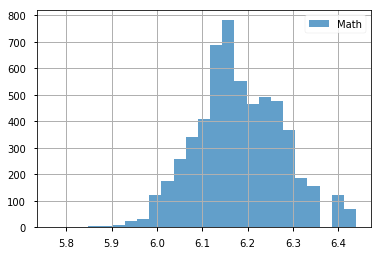

In [16]:
df.math.apply(lambda x:np.log(x)).hist(bins=25, alpha = 0.7, label = "Math") # Do we need to add +0.1?
plt.legend()
plt.show()


### Train/Test Split

In [17]:
X = df.drop('math', axis=1)
Y = np.log(df.math)

In [18]:
indices = range(df.shape[0])
i_schools = []
len_ischools = []

In [19]:
for s in schools:
    i_school = np.where(df.school == s)[0]
    len_ischools.append(len(i_school))
    i_schools.append(i_school)

In [20]:
min_len = min(len_ischools)
train_size = round(min_len*0.8)

In [21]:
train_idx = []
test_idx = []

In [22]:
for s in i_schools:
    np.random.shuffle(s)
    train_idx = np.concatenate((train_idx, s[:train_size]), axis=None)
    test_idx = np.concatenate((test_idx, s[train_size:]), axis=None)

In [23]:
len(train_idx)

2133

In [24]:
len(test_idx)

3615

In [25]:
X_train = X.iloc[train_idx,:]
X_test = X.iloc[test_idx,:]
Y_train = Y.iloc[train_idx]
Y_test = Y.iloc[test_idx]

## Pooled model 

In [26]:
pooled_code = """
data {
    int<lower=0>  N;
    int<lower=0> M;
    vector[N] x;
    vector[M] x_test;
    vector[N] y;
}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma);
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}

"""

In [27]:
import pystan

pool_data = {
    'N': df_train.shape[0], 
    'M': df_test.shape[0],
    'x': df_train.loc[:,'year_teaching'],
    'x_test': df_test.loc[:,'year_teaching'],
    'y': y_train,
}

NameError: name 'df_train' is not defined

In [28]:
pooled_fit = pystan.stan(model_code=pooled_code, data = pool_data, iter = 1000, chains = 2)
print(pooled_fit)

NameError: name 'pool_data' is not defined

In [29]:
pooled_sample = pooled_fit.extract(permuted=True)

loglik = (pooled_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("elpd_loo: ",psisloo.elpd)
#psisloo.plot()
lppd_pooled = 0 
for i in range (df_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print(peff_pooled)

NameError: name 'pooled_fit' is not defined

In [ ]:
b0, m0 = pooled_sample['beta'].T.mean(1)
plt.scatter(df.year_teaching, np.log(df.math))
xvals = np.linspace(0,30)
plt.plot(xvals, m0*xvals+b0, 'r--')
plt.show()



In [ ]:
#Comparing y_pred with y_test
MAE = np.sum(np.power(np.absolute(np.subtract(pooled_sample["y_pred_test"].mean(0), y_test)),2))
print(MAE)

##  Separate model

In [30]:
separate_code = """
data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] y_hat;  
    for (i in 1:N)
        y_hat[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(y_hat, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| y_hat[i], sigma);
}
"""

In [31]:
separate_data = {'N': df.shape[0],
                 'school': star.schidkn,
                 'x': df.loc[:,'year_teaching'],
                 'x_test': df.loc[:,'year_teaching'],
                 'y': np.log(df.math) }

In [32]:
separate_fit = pystan.stan(model_code = separate_code, data = separate_data, iter = 1000, chains = 2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0658457e53e8959415aa44ade4e33d07 NOW.
/Users/haicuthe/anaconda2/envs/dev-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [33]:
print(separate_fit)
separate_sample = separate_fit.extract(permuted=True)


Inference for Stan model: anon_model_0658457e53e8959415aa44ade4e33d07.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]        6.19  3.4e-4   0.01   6.17   6.18   6.19    6.2   6.21   1000    1.0
alpha[1]         6.1  4.0e-4   0.01   6.07   6.09    6.1   6.11   6.12   1000    1.0
alpha[2]        6.18  3.0e-4 9.5e-3   6.17   6.18   6.18   6.19    6.2   1000    1.0
alpha[3]        6.14  3.6e-4   0.01   6.12   6.13   6.14   6.15   6.16   1000    1.0
alpha[4]        6.12  3.7e-4   0.01    6.1   6.11   6.12   6.13   6.14   1000    1.0
alpha[5]        6.14  3.8e-4   0.01   6.12   6.14   6.14   6.15   6.17   1000    1.0
alpha[6]        6.23  2.6e-4 8.3e-3   6.21   6.22   6.23   6.23   6.24   1000    1.0
alpha[7]        6.15  3.1e-4 9.9e-3   6.13   6.15   6.15   6.16   6.17   1000    1.0
alpha[8]        6.17  2.7e-4 8.7e-3   6.16   6.1

In [34]:
separate_sample = pooled_fit.extract(permuted=True)

loglik = (separate_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("elpd_loo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (df.shape[1]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print(peff_pooled)

NameError: name 'pooled_fit' is not defined

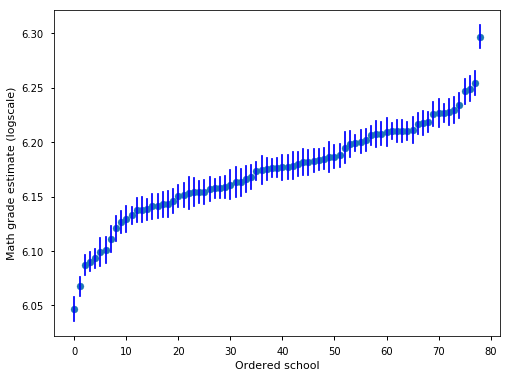

In [35]:
separate_sample = pd.Series(separate_fit['alpha'].mean(0), index=schools)
separate_sample_se = pd.Series(separate_fit['alpha'].std(0), index=schools)

order = separate_sample.sort_values().index
plt.figure(figsize = (8,6))
plt.scatter(range(len(separate_sample)), separate_sample[order])
for i, m, se in zip(range(len(separate_sample)), separate_sample[order], separate_sample_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.ylabel('Math grade estimate (logscale)');plt.xlabel('Ordered school');

# Hierarchical Model

In [36]:
min = len(df[df['school'] == 1])

for x in range(1, 80):
    if min > len(df[df['school'] == x]):
        min = len(df[df['school'] == x])

In [37]:
list = []
for x in range(1, 80):
    list.append(df.loc[df['school'] == x]['year_teaching'].values[:min].tolist())

In [38]:
y = np.asarray(list)

In [39]:
hierarchical_code = """
data {
    int<lower=1> J; // number of data points
    int<lower=1> K; // number of groups 
    matrix[J,K]  y; // measurements
}
parameters {
    real          mu0;
    real<lower=0> sigma0;
    vector[K]     mu;     // group means
    real<lower=0> sigma;  // shared std
}
model {
    for (k in 1:K){
      mu[k] ~ normal(mu0, sigma0);
      y[:,k] ~ normal(mu[k], sigma);    
    }
}
generated quantities {
    real mupred;
    vector[K] ypred;

    mupred <- normal_rng(mu0, sigma0);
    for (k in 1:K)
      ypred[k] <- normal_rng(mu[k], sigma);
}
"""
hierarchical_data = {
    'J': y.shape[0],
    'K': y.shape[1],
    'y': y
}

In [40]:
fit_hierarchical = pystan.stan(model_code=hierarchical_code, data=hierarchical_data, iter=3000, chains=20)
params_hierarchical = fit_hierarchical.extract()
print(fit_hierarchical)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c79179503378489b4e233029d799c2a NOW.


Inference for Stan model: anon_model_8c79179503378489b4e233029d799c2a.
20 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=30000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0         9.29  2.6e-3   0.12   9.07   9.21   9.29   9.37   9.52   2035   1.02
sigma0      0.17  6.0e-3    0.1   0.03   0.09   0.14   0.23   0.42    299   1.06
mu[0]       9.27  2.5e-3   0.21   8.84   9.16   9.27    9.4   9.68   7034    1.0
mu[1]       9.32  2.9e-3   0.21   8.91   9.19   9.31   9.44   9.78   5429   1.01
mu[2]       9.32  3.0e-3   0.21   8.92   9.19   9.31   9.44   9.78   4887   1.01
mu[3]       9.19  4.1e-3   0.23   8.62   9.08   9.22   9.34   9.57   3216   1.01
mu[4]        9.3  2.7e-3   0.21   8.87   9.17   9.29   9.42   9.73   6181   1.01
mu[5]       9.29  2.9e-3   0.21   8.86   9.17   9.28   9.41   9.71   5272   1.01
mu[6]       9.29  2.6e-3   0.21   8.87   9.17   9.29   9.41   9.71   6444    1.0

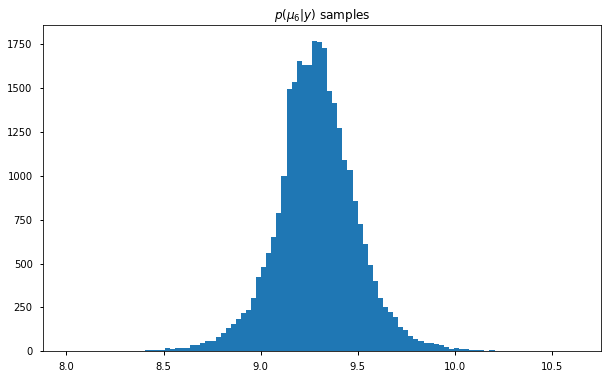

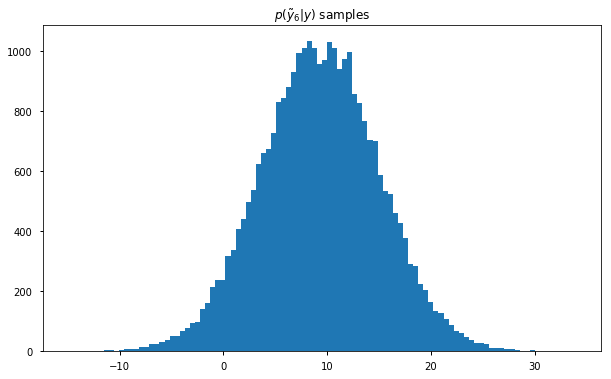

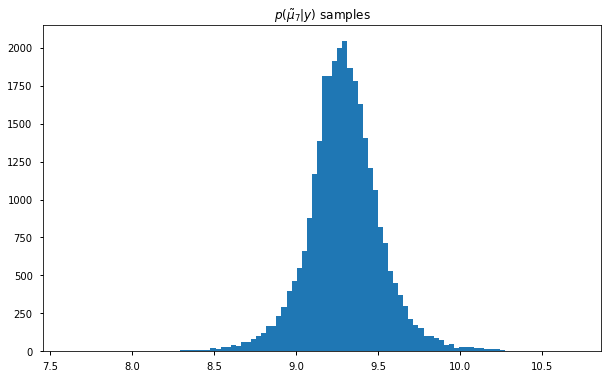

In [41]:
plt.figure(figsize=(10, 6))
plt.title(r'$p(\mu_6|y)$ samples')
_=plt.hist(params_hierarchical['mu'][:,5], bins=100)

plt.figure(figsize=(10, 6))
plt.title(r'$p(\tilde{y}_6|y)$ samples')
_=plt.hist(params_hierarchical['ypred'][:,5], bins=100)

plt.figure(figsize=(10, 6))
plt.title(r'$p(\tilde{\mu}_7|y)$ samples')
_=plt.hist(params_hierarchical['mupred'], bins=100)

plt.show()